In [1]:
# Instalar librerías necesarias
!pip install pandas numpy matplotlib seaborn psycopg2-binary textblob


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Cargar el dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import psycopg2
from sqlalchemy import create_engine

# Cargar el dataset
file_path = 'gym_members_exercise_tracking.csv'
df = pd.read_csv(file_path)

# Mostrar las primeras filas
print(df.head())


Could not save font_manager cache [Errno 13] Permission denied: 'C:\\Users\\LAPTO\\.matplotlib\\fontlist-v390.json.matplotlib-lock'


   Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
0                      1.69           1313.0         Yoga            12.6   
1                      1.30            883.0         HIIT            33.9   
2                      1.11            677.0       Cardio            33.4   
3                      0.59            532.0     Strength            28.8   
4                      0.64            556.0     Strength            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
0              

In [4]:
# Información básica del dataset
print("\nInformación del dataset:")
print(df.info())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df.describe(include='all'))


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/

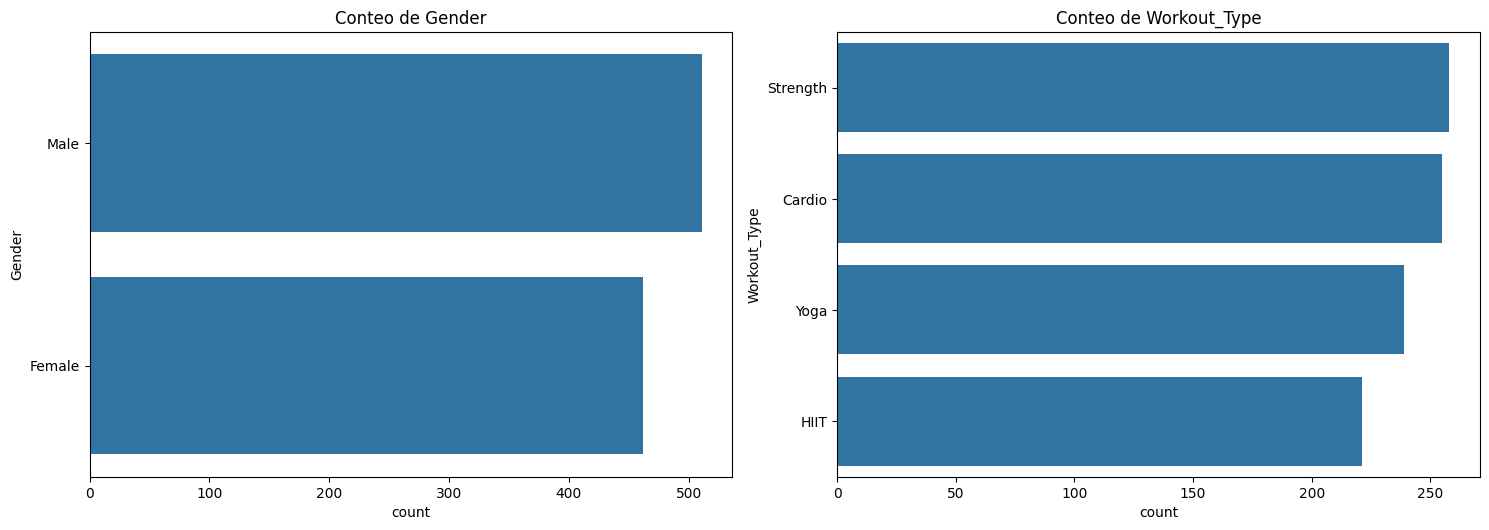

In [5]:
# Análisis de variables categóricas
cat_cols = df.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(cat_cols, 1):
        plt.subplot(2, 2, i)
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f'Conteo de {col}')
    plt.tight_layout()
    plt.show()

In [6]:
# Análisis de sentimientos
# Verificar si hay columnas de texto para análisis de sentimientos
text_cols = [col for col in df.columns if df[col].dtype == 'object' and col not in cat_cols]

if text_cols:
    print("\nAnálisis de sentimientos:")
    for col in text_cols:
        # Ejemplo: crear una nueva columna con el análisis de sentimiento
        df[f'{col}_sentiment'] = df[col].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
        
        # Mostrar resultados
        print(f"\nDistribución de sentimientos para {col}:")
        plt.figure(figsize=(8, 4))
        sns.histplot(df[f'{col}_sentiment'], bins=20, kde=True)
        plt.title(f'Distribución de sentimientos - {col}')
        plt.show()
        
        print(f"\nResumen de sentimientos para {col}:")
        print(df[f'{col}_sentiment'].describe())
else:
    print("\nNo se encontraron columnas de texto adecuadas para análisis de sentimientos.")


No se encontraron columnas de texto adecuadas para análisis de sentimientos.


In [11]:
import re

# Configuración de la conexión 
db_config = {
    'host': 'localhost',
    'database': 'gym',
    'user': 'postgres',
    'password': '1234',
    'port': '5432'
}

# Función para limpiar nombres de columnas
def clean_column_name(name):
    # Reemplazar caracteres especiales con _
    name = re.sub(r'[^a-zA-Z0-9_]', '_', str(name))
    # Eliminar múltiples _ consecutivos
    name = re.sub(r'_+', '_', name)
    # Eliminar _ al inicio o final
    name = name.strip('_')
    return name.lower()

# Limpiar nombres de columnas
df_clean = df.rename(columns=clean_column_name)

# Crear conexión
try:
    conn = psycopg2.connect(**db_config)
    cursor = conn.cursor()
    print("Conexión exitosa a PostgreSQL")
    
    # Crear tabla si no existe
    table_name = 'gym_members_exercise_tracking'
    
    # Generar la definición de columnas dinámicamente
    columns_def = []
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            columns_def.append(f'"{col}" TEXT')
        elif np.issubdtype(df_clean[col].dtype, np.integer):
            columns_def.append(f'"{col}" INTEGER')
        elif np.issubdtype(df_clean[col].dtype, np.floating):
            columns_def.append(f'"{col}" FLOAT')
        else:
            columns_def.append(f'"{col}" TEXT')
    
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        {', '.join(columns_def)}
    )
    """
    cursor.execute(create_table_query)
    conn.commit()
    print(f"Tabla {table_name} creada exitosamente")
    
    # Insertar datos (usando SQLAlchemy para mayor eficiencia)
    engine = create_engine(f'postgresql://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["database"]}')
    df_clean.to_sql(table_name, engine, if_exists='replace', index=False)
    print(f"Datos insertados correctamente en la tabla {table_name}")
    
except Exception as e:
    print(f"Error al conectar con PostgreSQL: {e}")
    # Imprimir el query que falló para debugging
    if 'create_table_query' in locals():
        print("Query que falló:", create_table_query)
finally:
    if 'conn' in locals() and conn:
        cursor.close()
        conn.close()

Conexión exitosa a PostgreSQL
Tabla gym_members_exercise_tracking creada exitosamente
Datos insertados correctamente en la tabla gym_members_exercise_tracking


In [12]:
# Exportar el dataframe con los análisis adicionales
output_path = "C:/Users/LAPTO/Downloads/gym_members_analysis.csv"
df.to_csv(output_path, index=False)
print(f"\nDataset exportado exitosamente a: {output_path}")


Dataset exportado exitosamente a: C:/Users/LAPTO/Downloads/gym_members_analysis.csv
